# CNN Cancer Detection Kaggle Mini-Project
This project is part of a [Kaggle competition](https://www.kaggle.com/c/histopathologic-cancer-detection/overview) focused on detecting metastatic cancer in small image patches extracted from larger digital pathology scans. The dataset used in this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset.



## Problem Description
The objective is to develop an algorithm capable of identifying metastatic cancer in small image patches. A positive label indicates that the central 32×32 pixel region of a patch contains at least one tumor tissue pixel, while tumor presence in the outer regions of the patch does not affect the label.

## Dataset

This dataset consists of a large collection of small pathology images intended for classification. The `train_labels.csv` file provides ground truth labels corresponding to the images in the training folder. The objective is to predict labels for the images in the test folder.  

Each image in the dataset measures 96x96 pixels and contains three color channels per pixel.  

The training set includes 220,025 images, while the test set comprises 57,458 images. Each image in the training set is labeled as either **0** (no cancer detected) or **1** (cancer detected).

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tifffile as tiff
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import plotly.express as px

from torch.utils.data import random_split
from torchvision import utils

from plotly.subplots import make_subplots
import plotly.graph_objs as go
from torch.utils.data import DataLoader
from torchsummary import summary

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from tqdm.notebook import tqdm
import seaborn as sns

In [2]:
# data_path = "/kaggle/input/histopathologic-cancer-detection"
data_path = "histopathologic-cancer-detection"
test_folder = f"{data_path}/test"
train_folder = f"{data_path}/train"
sample_submission = f"{data_path}/sample_submission.csv"
train_labels = f"{data_path}/train_labels.csv"

## Exploratory Data Analysis


Start by examining the data to understand the data types of the training dataset.

In [3]:
train_df = pd.read_csv(train_labels)
train_df.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


The training dataset consists of **220,025 samples**. It includes two key features: **id and label**, which indicate whether each image is classified as cancerous or cancer-free.



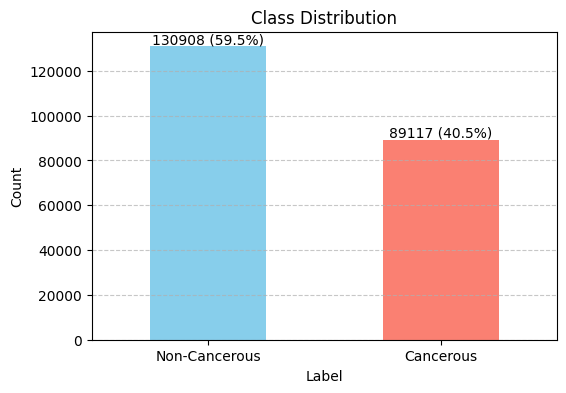

In [ ]:
label_counts = train_df['label'].value_counts()
label_percentages = (label_counts / label_counts.sum()) * 100

plt.figure(figsize=(6, 4))
bars = label_counts.plot(kind='bar', color=['skyblue', 'salmon'])

for bar, count, percent in zip(bars.patches, label_counts, label_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{count} ({percent:.1f}%)', 
             ha='center', va='bottom', fontsize=10)

plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=label_counts.index, labels=['Non-Cancerous', 'Cancerous'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


The data appears to be well-balanced, with 59.5% labeled as non-cancerous and 40.5% labeled as cancerous.







In [6]:
train_images = list(Path(train_folder).glob("*.tif"))
print(f"number of images is {len(train_images)}")
image = tiff.imread(train_images[0])
print(f"size of image is {image.shape}")

number of images is 220025
size of image is (96, 96, 3)


The training set contains **220,025 images**, which aligns perfectly with the number of training labels.

Additionally, the images have a consistent size of **[96, 96, 3]**, indicating they are **96x96 pixels** with **3 color channels (RGB)**.

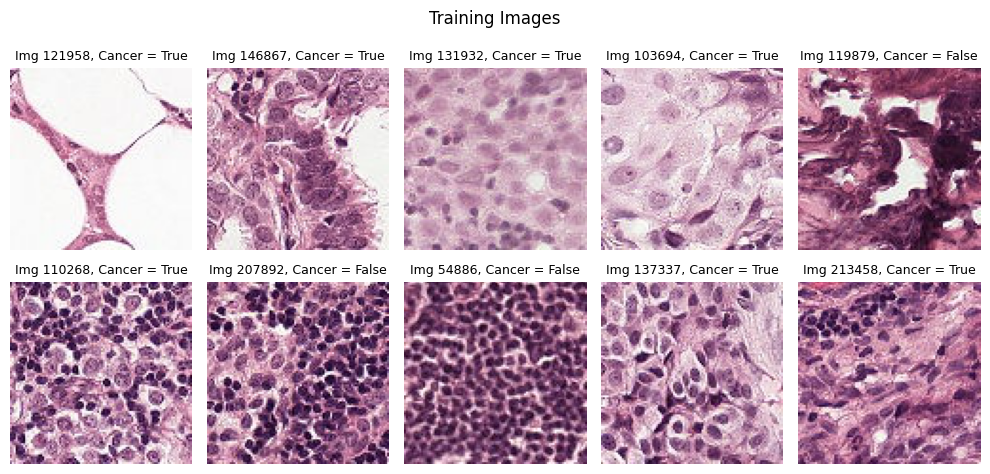

In [7]:
np.random.seed(42)

rand_indices = np.random.randint(0, len(train_images), size=10)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    image_path = train_images[rand_indices[i]]
    image_name = Path(image_path).stem
    image_mat = tiff.imread(image_path)

    ax.imshow(image_mat)
    
    has_cancer = bool(train_df.loc[train_df['id'] == image_name, 'label'].values[0])
    ax.set_title(f"Img {rand_indices[i]}, Cancer = {has_cancer}", fontsize=9)
    ax.axis("off")

fig.suptitle("Training Images", fontsize=12)
plt.tight_layout()
plt.show()

## Data Preparation
### Formatting the Dataset
Convert image data into a PyTorch-compatible dataset by creating a custom class that inherits from the torch.utils.data.Dataset class.

In [8]:
torch.manual_seed(0)

class PytorchDataset(Dataset):
    def __init__(self, images, data, transform, mode="test", sample_size=None):
        """
        Custom PyTorch Dataset for loading images and labels.

        Args:
            images (list): List of image file paths.
            transform (callable): Transformations to apply to images.
            sample_size (int): Number of samples to select from the dataset. For training only
        """
        self.full_filenames = images if mode == "test" else sorted(images)

        if sample_size is not None and sample_size < len(self.full_filenames):
            selected_indices = np.random.choice(len(self.full_filenames), sample_size, replace=False)
            self.full_filenames = [self.full_filenames[i] for i in selected_indices]
            print(f"Selected {len(self.full_filenames)} images.")
        
        labels_df = data.set_index("id")  

        self.labels = [labels_df.loc[path.stem].values[0] for path in self.full_filenames]
        self.transform = transform

    def __len__(self):
        return len(self.full_filenames)  

    def __getitem__(self, idx):
        """
        Retrieves an image and its corresponding label.
        """
        image = Image.open(self.full_filenames[idx])  
        image = self.transform(image)  
        label = self.labels[idx]  
        
        return image, label

In [9]:
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((48,48), antialias=True)])

# Use 6000 images for training
img_dataset = PytorchDataset(train_images, train_df, data_transformer, "train", 6000)

Selected 6000 images.


Check generated image dataset

In [10]:
img, label=img_dataset[10]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 48, 48]) tensor(0.2130) tensor(0.9709)


### Splitting the Data
We will divide the dataset into 80% for training and 20% for validation.

In [11]:
train_size = int(0.8 * len(img_dataset))
val_size = len(img_dataset) - train_size

train_set, val_set = random_split(img_dataset, [train_size, val_size])

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")

# Preview the first 6 samples from the training set
for i, (image, label) in enumerate(train_set):
    print(image.shape, label)
    if i == 5:
        break

Training set size: 4800
Validation set size: 1200
torch.Size([3, 48, 48]) 1
torch.Size([3, 48, 48]) 0
torch.Size([3, 48, 48]) 1
torch.Size([3, 48, 48]) 1
torch.Size([3, 48, 48]) 1
torch.Size([3, 48, 48]) 0


Here we want to plot some cancer images in training and validation set

In [ ]:
def plot_image(tensor_img, title=None):
    """
    Convert a tensor image to a NumPy array and display it using Plotly.

    Args:
        tensor_img (Tensor): Image tensor to display.
        title (str, optional): Title for the plot.
    """
    np_img = tensor_img.numpy()  
    np_img_tr = np.transpose(np_img, (1, 2, 0))  # Convert to H*W*C format
    
    fig = px.imshow(np_img_tr)
    fig.update_layout(
        template='plotly_white',
        title=title,
        height=300,
        margin={'l': 10, 'r': 20, 'b': 10}
    )
    fig.show()

In [ ]:
grid_size = 26
random_indices = np.random.randint(0, len(train_set), grid_size)
print("Selected image indices:", random_indices)

image_grid = [train_set[i][0] for i in random_indices]

image_grid_tensor = utils.make_grid(image_grid, nrow=13, padding=2)
print("Grid shape:", image_grid_tensor.shape)

plot_image(image_grid_tensor, title='Training Subset Examples')

Selected image indices: [4125 2034 1302  399 4463 3026  720  881 2098 3337 2896 2797 3358 4391
  546 3619  857  952 2998 1151 1623 1437 4749 3578 4786 2359]
Grid shape: torch.Size([3, 102, 652])


In [ ]:
grid_size = 26
random_indices = np.random.randint(0, len(val_set), grid_size)
print("Selected image indices:", random_indices)

image_grid = [val_set[i][0] for i in random_indices]

image_grid_tensor = utils.make_grid(image_grid, nrow=13, padding=2)
print("Grid shape:", image_grid_tensor.shape)

plot_image(image_grid_tensor, title='Validation Dataset Examples')

Selected image indices: [ 383  338 1060 1034  618  746  934  837  142   62  953  278  917  363
 1198  940  414  531  461  831  899  430  679  272  811  491]
Grid shape: torch.Size([3, 102, 652])


### **Incorporating Image Transformations**  

When developing deep learning models, integrating **pre-trained models, image transformations, and enhancements** plays a crucial role in optimizing performance. Image transformations allow us to **augment our dataset**, resize images, and normalize pixel values to improve model generalization.

Common image transformations include **horizontal flipping, vertical flipping, rotation, and resizing**. These techniques can be applied to our **binary classification model** without altering the labels. For instance, **flipping or rotating a malignant image** does not change its classification.

In [ ]:
train_set.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
    transforms.Resize((48, 48), antialias=True)
])

In [ ]:
train_loader = DataLoader(train_set,
                      batch_size=32, 
                      shuffle=True)

val_loader = DataLoader(val_set,
                    batch_size=32,
                    shuffle=False)

## Model building
### Binary Classification Model
* Convolutional Layers: The model consists of four Conv2D layers, each followed by a max pooling (MaxPool2D) layer to reduce spatial dimensions.
* Fully Connected Layers: Two fully connected (FC) layers are included, with a dropout layer in between to mitigate overfitting.
* Activation Function: The final layer utilizes log_softmax as the activation function, ensuring stable probability outputs for binary classification.

In [16]:
def compute_conv2d_output_shape(h_in, w_in, conv_layer, pool=2):
    """
    Computes the output height and width of a Conv2D layer.
    
    Args:
        h_in (int): Input height.
        w_in (int): Input width.
        conv_layer (nn.Conv2d): Convolutional layer.
        pool (int or None): Pooling factor (default is 2 for MaxPooling).
    
    Returns:
        (int, int): Output height and width after the convolution (and pooling if applicable).
    """
    kernel_size = conv_layer.kernel_size
    stride = conv_layer.stride
    padding = conv_layer.padding
    dilation = conv_layer.dilation

    h_out = np.floor((h_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
    w_out = np.floor((w_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)

    if pool:
        h_out /= pool
        w_out /= pool

    return int(h_out), int(w_out)


class CNNClassifier(nn.Module):
    """
    A Convolutional Neural Network (CNN) for binary classification.
    """
    def __init__(self, params):
        super(CNNClassifier, self).__init__()

        # Extract model parameters
        in_channels, h_in, w_in = params["shape_in"]
        init_filters = params["initial_filters"]
        fc1_units = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        # Define Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels, init_filters, kernel_size=3)
        h_out, w_out = compute_conv2d_output_shape(h_in, w_in, self.conv1)

        self.conv2 = nn.Conv2d(init_filters, init_filters * 2, kernel_size=3)
        h_out, w_out = compute_conv2d_output_shape(h_out, w_out, self.conv2)

        self.conv3 = nn.Conv2d(init_filters * 2, init_filters * 4, kernel_size=3)
        h_out, w_out = compute_conv2d_output_shape(h_out, w_out, self.conv3)

        self.conv4 = nn.Conv2d(init_filters * 4, init_filters * 8, kernel_size=3)
        h_out, w_out = compute_conv2d_output_shape(h_out, w_out, self.conv4)

        # Compute the number of flattened features
        self.num_flattened = h_out * w_out * init_filters * 8

        # Define Fully Connected Layers
        self.fc1 = nn.Linear(self.num_flattened, fc1_units)
        self.fc2 = nn.Linear(fc1_units, num_classes)

    def forward(self, x):
        """
        Defines the forward pass of the CNN model.
        """
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten the tensor for the fully connected layer
        x = x.view(-1, self.num_flattened)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout_rate)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


### Build CNN model

In [ ]:
model_params = {
    "shape_in": (3, 48, 48),  
    "initial_filters": 8,    
    "num_fc1": 100,
    "dropout_rate": 0.25,
    "num_classes": 2
}

cnn_model = CNNClassifier(model_params)

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = cnn_model.to(device)

# Display model summary
# TODO: re-enable when using cuda
# summary(cnn_model, input_size=(3, 48, 48), device=device.type)
print(cnn_model)

Using device: mps
CNNClassifier(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


#### Loss Function
In binary classification, models can have one or two output units. It's advisable to use log_softmax, as it scales well to multiclass problems. PyTorch provides a combined log_softmax function that ensures numerical stability and efficiency.

#### Optimizer
The optimizer manages the model's parameters and updates them using the computed gradients. For binary classification, popular choices include SGD and Adam; in this case, we use Adam. The optimizer iteratively minimizes the loss function, thereby improving the model's predictive accuracy.

In [ ]:
# Configuration Class
class TrainConfig:
    def __init__(self, model, train_loader, val_loader):
        self.epochs = 50
        self.learning_rate = 3e-4
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.loss_function = nn.NLLLoss(reduction="sum")
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.lr_scheduler = ReduceLROnPlateau(
            self.optimizer, mode="min", factor=0.5, patience=20
        )
        self.weight_path = "weights.pt"


def get_learning_rate(optimizer):
    return optimizer.param_groups[0]["lr"]

def compute_batch_loss(loss_func, outputs, targets, optimizer=None):
    loss = loss_func(outputs, targets)
    predictions = outputs.argmax(dim=1, keepdim=True)
    correct_preds = predictions.eq(targets.view_as(predictions)).sum().item()

    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item(), correct_preds

def compute_epoch_loss(model, loss_func, data_loader, optimizer=None):
    total_loss = 0.0
    total_correct = 0
    total_samples = len(data_loader.dataset)

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        batch_loss, correct_preds = compute_batch_loss(loss_func, outputs, labels, optimizer)

        total_loss += batch_loss
        total_correct += correct_preds

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy

def train_and_validate(config: TrainConfig, verbose=False):
    """
    Train and validate the CNN model.

    Args:
        config (TrainConfig): Configuration object with training parameters.
        verbose (bool): Whether to print detailed training logs.

    Returns:
        model (nn.Module): Best trained model.
        loss_history (dict): Training and validation loss history.
        metric_history (dict): Training and validation accuracy history.
    """
    model = config.model
    loss_func = config.loss_function
    optimizer = config.optimizer
    train_loader = config.train_loader
    val_loader = config.val_loader
    lr_scheduler = config.lr_scheduler
    weight_path = config.weight_path
    epochs = config.epochs

    loss_history = {"train": [], "val": []}
    metric_history = {"train": [], "val": []}

    best_model_weights = copy.deepcopy(model.state_dict())
    best_loss = float("inf")

    for epoch in tqdm(range(epochs), desc="Training Progress"):
        current_lr = get_learning_rate(optimizer)

        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, Learning Rate: {current_lr}")

        # Train the model
        model.train()
        train_loss, train_acc = compute_epoch_loss(model, loss_func, train_loader, optimizer)

        # Validate the model
        model.eval()
        with torch.no_grad():
            val_loss, val_acc = compute_epoch_loss(model, loss_func, val_loader)

        # Store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), weight_path)

            if verbose:
                print("Best model weights saved!")

        # Update learning rate
        lr_scheduler.step(val_loss)

        # Restore best weights if learning rate changes
        if current_lr != get_learning_rate(optimizer):
            if verbose:
                print("Restoring best model weights!")
            model.load_state_dict(best_model_weights)

        # Store training history
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_acc)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_acc)

        if verbose:
            print(f"Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}, Accuracy: {val_acc * 100:.2f}%")
            print("-" * 40)

    # Load best model weights
    model.load_state_dict(best_model_weights)

    return model, loss_history, metric_history


# Initialize training configuration
train_config = TrainConfig(cnn_model, train_loader, val_loader)




In [20]:
# Train and validate the model
cnn_model, loss_history, metric_history = train_and_validate(train_config, verbose=True)

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Learning Rate: 0.0003
Best model weights saved!
Train Loss: 0.677852, Validation Loss: 0.679060, Accuracy: 57.50%
----------------------------------------
Epoch 2/50, Learning Rate: 0.0003
Best model weights saved!
Train Loss: 0.652195, Validation Loss: 0.624386, Accuracy: 69.75%
----------------------------------------
Epoch 3/50, Learning Rate: 0.0003
Best model weights saved!
Train Loss: 0.570351, Validation Loss: 0.515053, Accuracy: 76.75%
----------------------------------------
Epoch 4/50, Learning Rate: 0.0003
Train Loss: 0.518150, Validation Loss: 0.522793, Accuracy: 75.33%
----------------------------------------
Epoch 5/50, Learning Rate: 0.0003
Best model weights saved!
Train Loss: 0.502957, Validation Loss: 0.507697, Accuracy: 77.17%
----------------------------------------
Epoch 6/50, Learning Rate: 0.0003
Train Loss: 0.499564, Validation Loss: 0.538167, Accuracy: 74.25%
----------------------------------------
Epoch 7/50, Learning Rate: 0.0003
Best model weigh

Draw the graph of loss and accuracy

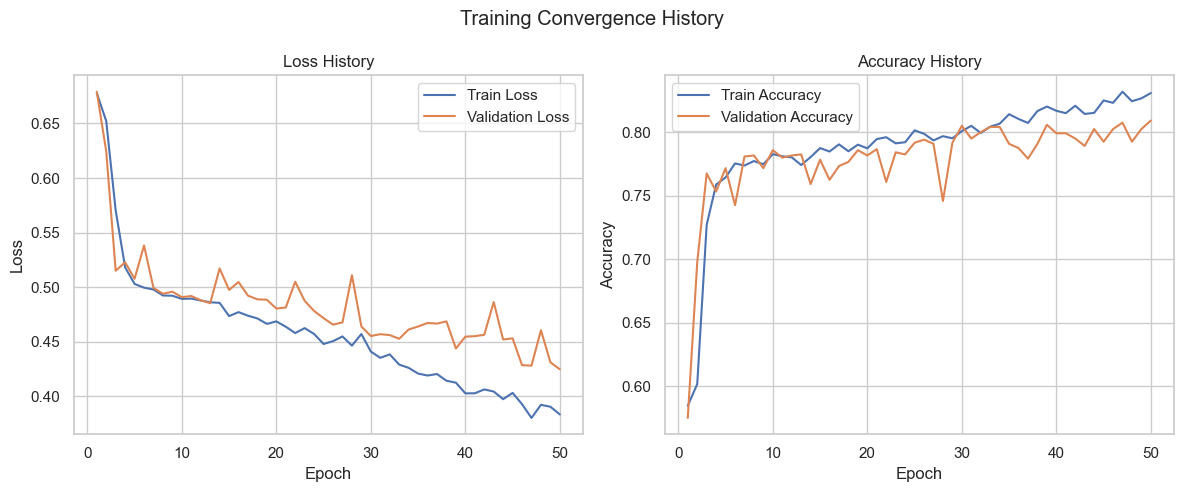

In [21]:
sns.set(style="whitegrid")

epochs = train_config.epochs

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

epoch_range = list(range(1, epochs + 1))

# Plot Loss History
sns.lineplot(x=epoch_range, y=loss_history["train"], ax=axes[0], label="Train Loss")
sns.lineplot(x=epoch_range, y=loss_history["val"], ax=axes[0], label="Validation Loss")
axes[0].set_title("Loss History")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Plot Accuracy History
sns.lineplot(x=epoch_range, y=metric_history["train"], ax=axes[1], label="Train Accuracy")
sns.lineplot(x=epoch_range, y=metric_history["val"], ax=axes[1], label="Validation Accuracy")
axes[1].set_title("Accuracy History")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")

fig.suptitle("Training Convergence History")

plt.tight_layout()
plt.show()


So from the loss history, we can see that epoch=50 is great for not overfitting. Now let's check the generated 'weights.pt' file

In [22]:
!ls

CNN_submission.csv               histopathologic-cancer-detection
cancer-cnn.ipynb                 weights.pt


Load model weight file if needed

In [23]:
cnn_model.load_state_dict(torch.load('weights.pt'))

<All keys matched successfully>

### Test
Similar to training dataset, we need to create a data loader for testing dataset. 

In [24]:
testing_images = list(Path(test_folder).glob("*.tif"))
test_df = pd.read_csv(sample_submission)
test_df.head()

id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

In [25]:
img_dataset_test = PytorchDataset(testing_images, test_df, data_transformer)
print(len(img_dataset_test), 'samples found')

57458 samples found


#### Get prediction

In [26]:
def inference(model, dataset, device, num_classes=2):
    num_samples = len(dataset)
    predictions = torch.zeros(num_samples, num_classes)
    true_labels = np.zeros(num_samples, dtype="uint8")
    model = model.to(device)
    
    with torch.no_grad():
        for idx in tqdm(range(num_samples)):
            input_tensor, label = dataset[idx]
            true_labels[idx] = label
            predictions[idx] = model(input_tensor.unsqueeze(0).to(device))
    
    return predictions.numpy(), true_labels

In [27]:
y_test, _ = inference(cnn_model,img_dataset_test, device)            


  0%|          | 0/57458 [00:00<?, ?it/s]

In [28]:
y_test_pred = np.argmax(y_test, axis=1)

In [29]:
print(y_test_pred)

[1 1 1 ... 0 0 1]


Create the csv file for submission

In [34]:
for path in img_dataset_test.full_filenames:
    print(path.stem)

fd0a060ef9c30c9a83f6b4bfb568db74b099154d
1f9ee06f06d329eb7902a2e03ab3835dd0484581
19709bec800f372d0b1d085da6933dd3ef108846
7a34fc34523063f13f0617f7518a0330f6187bd3
93be720ca2b95fe2126cf2e1ed752bd759e9b0ed
761dde7de22cb39a0dd67ce472163d66e5ac1568
58055ce8819717a100b48d019e139be4fdf997c0
9735b584631f4b942b022d40aecdbe2aa8f6ae5e
860bbd33f8483a45858c4998021bc7434117deda
99050fbce64ae16e48e8a3b09d38f3b16df63fbe
3091e877b92112604324f4af82735f64cf07a50c
9b2ee1deca30e1d7c8e515d620aff1b137ba4474
8f15b3139e3ff9e60d2a6305b57d90b21e48a378
1f9fe04059309fb60e5db14bd8a38d059935f563
b9ece5c8fbd1564c1748fd9a3d7ed2a5b415518e
706eaf697e8e5cbd3bd97229a097d7452a6f2441
a4565425b5bd53063031eaa93ccfbc40925702a5
e9e499f23d9d35a25400ae31c5812e85cd7e1795
b25a3102aeacf7dc451b4b400d7759eab1c484e2
5c9653d46db79c7a6028e128c3972318d3762ba3
aa532a860714f0a974f71d72984ed13fdbeeaf6e
18bcfda3795227c51b4fadbf510086e968aa56ee
7987fdc087812023f8fc198261dedb0b81e1cd25
8db34d33422b63842b05b7525b1aecf61f20dcca
6dea25581f86916b

In [35]:
submission_df = pd.DataFrame({
    'id': [path.stem for path in img_dataset_test.full_filenames],
    'label': y_test_pred
})


In [36]:
print(submission_df)

                                             id  label
0      fd0a060ef9c30c9a83f6b4bfb568db74b099154d      1
1      1f9ee06f06d329eb7902a2e03ab3835dd0484581      1
2      19709bec800f372d0b1d085da6933dd3ef108846      1
3      7a34fc34523063f13f0617f7518a0330f6187bd3      0
4      93be720ca2b95fe2126cf2e1ed752bd759e9b0ed      0
...                                         ...    ...
57453  2581931c6ef068f105a872f2c5500275fc678242      0
57454  11b250a664d09ab59fd2afbdb2f8d786763b185d      1
57455  18a6030935ec1ef1ce486ec51bc95abb4008fbf1      0
57456  f541404e501e23a0188c852eb37eac94053cfdc0      0
57457  3cb6f5e2db8ad046c946b581fa12d20df5ce2927      1

[57458 rows x 2 columns]


In [37]:
submission_df.to_csv('CNN_submission.csv', index=False)

## Conclusion
This project provided valuable insights into applying Convolutional Neural Networks (CNNs) for cancer detection in medical imaging. Key takeaways include:

* **Model Evaluation Metrics**: While AUC is a robust metric that evaluates performance across all classification thresholds, it complicates model compilation. In practice, metrics like precision, recall, and confusion matrices—based on fixed thresholds (commonly 0.5)—are often more straightforward for evaluation.

* **Effect of Transfer Learning**: Integrating transfer learning introduced greater model complexity. Models pre-trained on large, diverse datasets brought in external knowledge, enhancing the ability to detect intricate patterns in medical images. Additionally, transfer learning helped mitigate overfitting issues.

* **Data Processing Challenges**: Handling large datasets posed significant difficulties. I experimented with efficient data loading techniques, such as converting images into int8 NumPy arrays. However, this method proved memory-intensive and adversely affected model training performance.

**Future Directions**:

* **Focus on Key Image Regions**: Cropping images to emphasize the central 32x32 pixel region—where cancer indicators are most prominent—may improve both model efficiency and accuracy.

* **Experiment with Alternative Metrics**: Exploring other metrics, such as accuracy, could offer new perspectives on performance. However, ensuring a balanced dataset is essential for meaningful accuracy assessments.

* **Address AUC Discrepancies**:

  * Implement data augmentation and dropout to reduce overfitting.
  * Increase the size of the validation set to better reflect the model’s generalization capabilities.